In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [26]:
import os

# Check contents of the folder to verify the path
folder_path = '/content/drive/MyDrive/imgprocess'
print(os.listdir(folder_path))


['jason_holder', 'shoaib_malik', 'shadab_khan', 'shikhar_dhawan', 'sarfaraz_ahmed', 'steve_smith', 'jason_behrendorff', 'samiullah_shinwari', 'shimron_hetmyer', 'shakib_al_hasan']


In [34]:
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to preprocess an image (applying multiple transformations)
def preprocess_image(img):
    # Grayscale Conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Red and Blue Scaling
    img[:, :, 0] = img[:, :, 0] * random.uniform(0.5, 1.5)  # Blue Channel
    img[:, :, 2] = img[:, :, 2] * random.uniform(0.5, 1.5)  # Red Channel

    # Histogram Equalization
    gray_img = cv2.equalizeHist(gray_img)

    # Resize image to a standard size (128x128)
    img_resized = cv2.resize(img, (128, 128))

    # Brightness/Contrast Adjustment
    alpha = random.uniform(0.7, 1.3)  # Contrast control
    beta = random.randint(-30, 30)    # Brightness control
    img_bright_contrast = cv2.convertScaleAbs(img_resized, alpha=alpha, beta=beta)

    # Blurring
    img_blurred = cv2.GaussianBlur(img_bright_contrast, (5, 5), 0)

    # Edge Detection
    edges = cv2.Canny(img_blurred, 100, 200)

    # Sharpening (using a kernel)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    img_sharpened = cv2.filter2D(img_bright_contrast, -1, kernel)

    return img_sharpened  # Return the preprocessed image

# Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the pixel values
    rotation_range=30,  # Random rotations up to 30 degrees
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest',  # Fill the empty pixels after transformations
    validation_split=0.2  # Split the dataset into training and validation
)

# Load images from directory
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/imgprocess',  # Path to your directory containing the images
    target_size=(128, 128),  # Resize the images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multiple classes (cricketer names)
    subset='training'  # This will use the training subset
)

val_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/imgprocess',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

print("Data loading and augmentation completed.")


Found 116 images belonging to 10 classes.
Found 25 images belonging to 10 classes.
Data loading and augmentation completed.


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD  # Stochastic Gradient Descent optimizer (with momentum)

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

# Load VGG16 pre-trained model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Define the batch size
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]  # Add early stopping
)

# Save the trained model
model.save('/content/cricketer_model_with_momentum.h5')
print("Model trained and saved with momentum.")


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1376 - loss: 3.5911 - val_accuracy: 0.0800 - val_loss: 2.7157
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.1904 - loss: 3.1413 - val_accuracy: 0.2800 - val_loss: 2.1883
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.2185 - loss: 2.6227 - val_accuracy: 0.2000 - val_loss: 2.4562
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.3033 - loss: 2.3953 - val_accuracy: 0.3200 - val_loss: 1.9986
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.4279 - loss: 1.7273 - val_accuracy: 0.3600 - val_loss: 2.1100
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.3635 - loss: 1.7768 - val_accuracy: 0.4800 - val_loss: 2.0797
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.4045 - loss: 1.6179 - val_accuracy: 0.3600 - val_loss: 2.0866
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.5172 - loss: 1.4598 - val_accuracy: 0.4400 - val_

Model trained and saved with momentum.


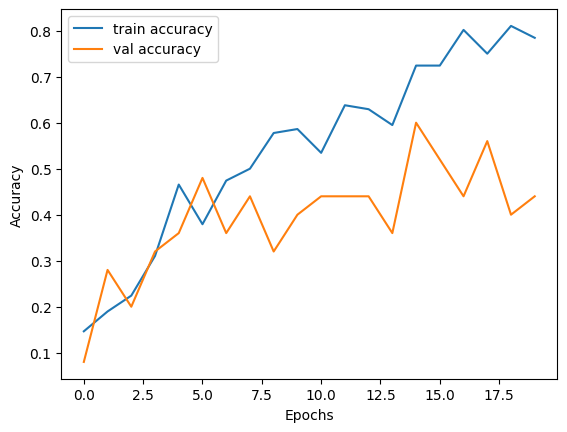

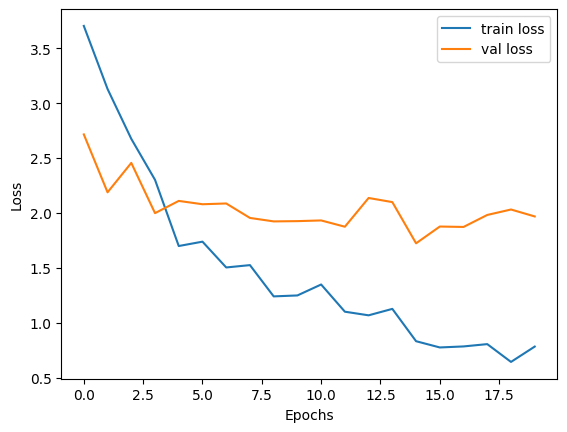

In [36]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
# Adjusting data augmentation with larger range
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/imgprocess',  # Path to your directory containing the images
    target_size=(128, 128),  # Resize the images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multiple classes (cricketer names)
    subset='training'  # This will use the training subset
)

# Unfreeze the last few layers of ResNet50 for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Model re-compilation with reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping and ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[early_stopping, lr_scheduler]
)


Found 141 images belonging to 10 classes.
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 872ms/step - accuracy: 0.3678 - loss: 1.8603 - val_accuracy: 0.3600 - val_loss: 1.7687 - learning_rate: 1.0000e-04
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.3626 - loss: 1.8043 - val_accuracy: 0.5200 - val_loss: 1.5056 - learning_rate: 1.0000e-04
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.4397 - loss: 1.7310 - val_accuracy: 0.5200 - val_loss: 1.3215 - learning_rate: 1.0000e-04
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.4474 - loss: 1.5576 - val_accuracy: 0.6400 - val_loss: 1.1827 - learning_rate: 1.0000e-04
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5242 - loss: 1.4140 - val_accuracy: 0.6000 - val_loss: 1.1725 - learning_rate: 1.0000e-04
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.4139 - loss: 1.5874 - val_accuracy: 0.6800 - val_loss: 1.0131 - learning_rate: 1.0000e-04
Epoch 7/100
5/5 ━━━━━━━━━━━

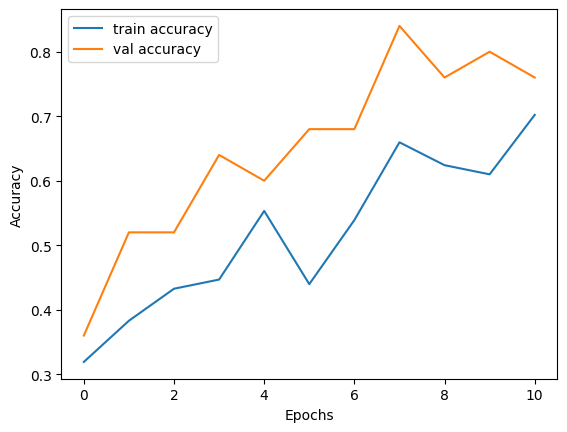

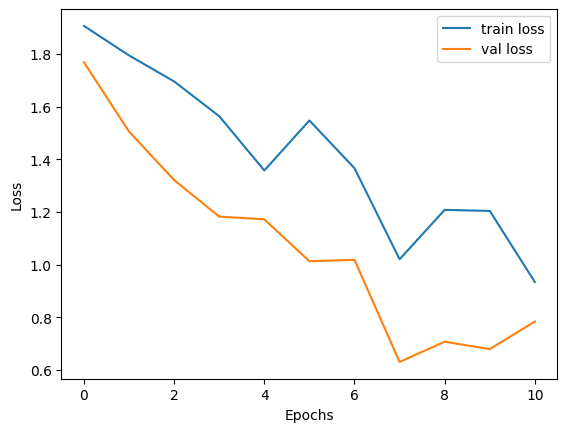

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


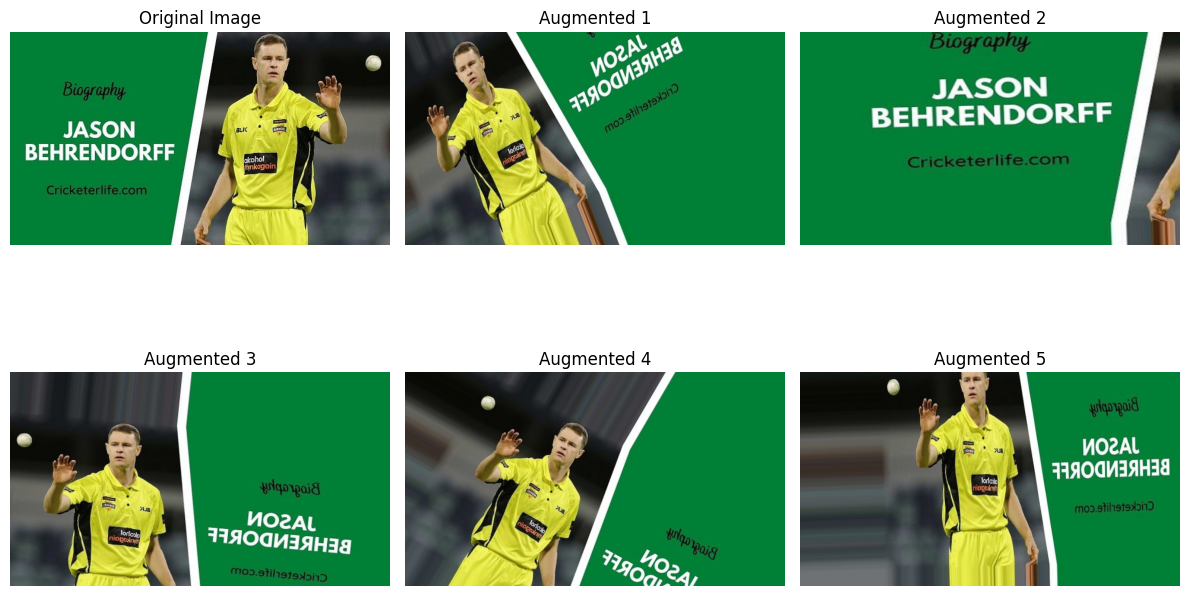

In [43]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load a sample image (replace with your own image path)
image_path = "/content/drive/MyDrive/imgprocess/jason_behrendorff/176976bc0a.jpg"  # Change this path to your image
img = load_img(image_path)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Initialize the ImageDataGenerator for various transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply transformations
#augmented_images = []
aug_iter = train_datagen.flow(img_array, batch_size=1)

# Plot original image and augmented versions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Display original image
axes[0, 0].imshow(img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# Generate and display augmented images
for i in range(1, 6):  # Start from index 1 because 0 is for the original image
    augmented_img = next(aug_iter)  # Get the next augmented image
    axes[i // 3, i % 3].imshow(augmented_img[0])  # Use [0] to get the image from the batch
    axes[i // 3, i % 3].set_title(f"Augmented {i}")
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()
